#### 「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第3部第10章 交互作用：カテゴリ×数量」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# カテゴリ×数量：モデル化
## 分析対象のデータ

In [2]:
interaction_2 = pd.read_csv('3-10-2-interaction-2.csv')
interaction_2.head(n=3)

,sales,publicity,temperature
0,74.0,not,8.0
1,60.2,not,11.2
2,91.2,not,17.2


## データの要約

In [3]:
interaction_2.describe(include='all')

,sales,publicity,temperature
count,100.000000,100,100.000000
unique,NaN,2,NaN
top,NaN,not,NaN
freq,NaN,50,NaN
mean,123.465000,NaN,15.539000
std,59.476515,NaN,8.023537
min,25.900000,NaN,0.400000
25%,79.675000,NaN,9.725000
50%,109.500000,NaN,14.650000
75%,154.450000,NaN,23.025000


## 参考：デザイン行列の作成

In [4]:
# ダミー変数化処理
design_mat = pd.get_dummies(interaction_2.drop(['sales'], axis=1),
                            drop_first=True)

# 交互作用項の追加
design_mat['publicity_to_implement:temperature'] = design_mat[
    'publicity_to_implement'] * design_mat['temperature']

# (Intercept)列追加
design_mat.insert(0, '(Intercept)', 1)

display(design_mat)

,(Intercept),temperature,publicity_to_implement,publicity_to_implement:temperature
0,1,8.0,0,0.0
1,1,11.2,0,0.0
2,1,17.2,0,0.0
3,1,27.2,0,0.0
4,1,6.1,0,0.0
...,...,...,...,...
95,1,23.9,1,23.9
96,1,13.7,1,13.7
97,1,12.3,1,12.3
98,1,24.3,1,24.3


## 参考：dictにまとめる

In [5]:
data_dict = dict(N=len(interaction_2),
                 sales=interaction_2['sales'],
                 publicity=design_mat['publicity_to_implement'],
                 temperature=design_mat['temperature'],
                 publicity_temperature=design_mat['publicity_to_implement:temperature'],
                 N_pred = len(np.arange(0, 30, 0.1)),       # 事後予測分布生成用
                 temperature_pred = np.arange(0, 30, 0.1))  # 事後予測分布生成用

## モデル化

In [7]:
# stanコードの記述
stan_code = '''
data {
    int N;
    vector[N] sales;
    vector[N] publicity;
    vector[N] temperature;
    vector[N] publicity_temperature;
    int N_pred;
    vector[N_pred] temperature_pred;
}

parameters {
    real Intercept;
    real b_publicity;
    real b_temperature;
    real b_publicity_temperature;
    real<lower=0> sigma;
}

model {
    vector[N] mu = Intercept + b_publicity*publicity + b_temperature*temperature + b_publicity_temperature*publicity_temperature;
    sales ~ normal(mu, sigma);
}

// 宣伝なし/あり についてmuの事後予測分布を生成
generated quantities {
    vector[N_pred] mu_pred_not;
    vector[N_pred] mu_pred_to_implement;    
    for(i in 1:N_pred){
        // 宣伝なし
        mu_pred_not[i] = Intercept + b_publicity*0 + b_temperature*temperature_pred[i] + b_publicity_temperature*temperature_pred[i]*0;
        // 宣伝あり
        mu_pred_to_implement[i] = Intercept + b_publicity*1 + b_temperature*temperature_pred[i] + b_publicity_temperature*temperature_pred[i]*1;
    }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
interaction_stan_2 = stan_model.sampling(data=data_dict, seed=2, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7865fdabec4109b45d2e6844e116af9 NOW.


## MCMCの結果の確認

In [8]:
print(interaction_stan_2.stansummary(probs=[0.025, 0.5, 0.975],
                                     pars=['Intercept', 
                                           'b_publicity',
                                           'b_temperature',
                                           'b_publicity_temperature',
                                           'sigma']
                                    ))

Inference for Stan model: anon_model_729b5793c2b95ce1a798a5cda5f27fd5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept                43.14    0.16    6.0  31.56  43.15  54.86   1381    1.0
b_publicity              17.23    0.22   8.31   0.97  17.38  33.37   1390    1.0
b_temperature             2.58  9.0e-3   0.33   1.92   2.59   3.23   1350    1.0
b_publicity_temperature    4.2    0.01   0.48   3.23   4.19   5.15   1385    1.0
sigma                    18.74    0.03   1.39  16.27  18.69  21.62   2408    1.0

Samples were drawn using NUTS at Wed Sep  9 19:40:08 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：事後分布の図示

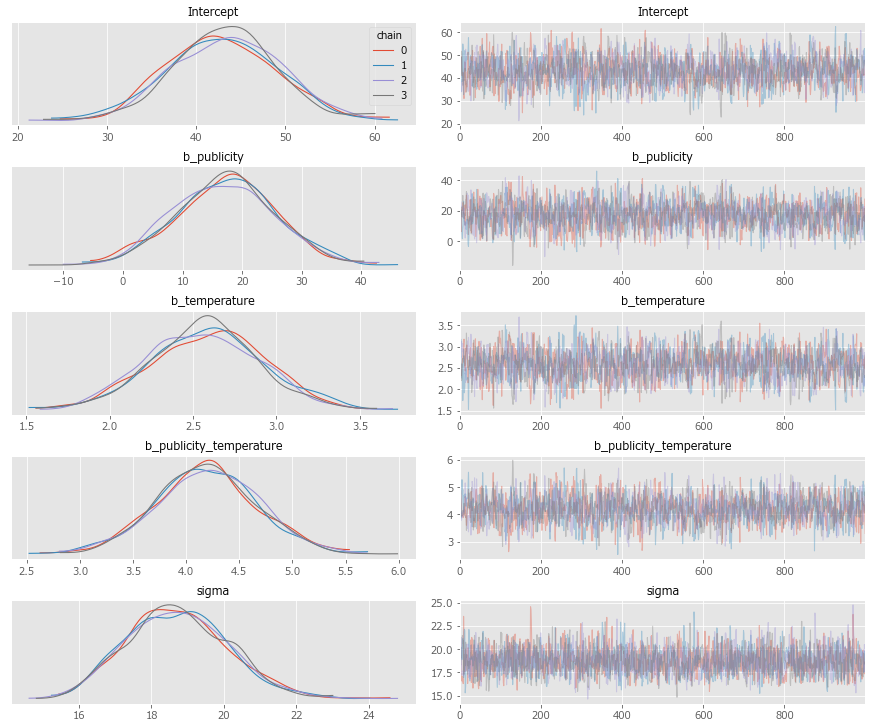

In [11]:
arviz.plot_trace(interaction_stan_2,
                 var_names=['Intercept', 
                            'b_publicity',
                            'b_temperature',
                            'b_publicity_temperature',
                            'sigma'],
                 legend=True);

# カテゴリ×数量：係数の解釈

## 説明変数を作る

In [12]:
newdata_2 = np.matrix([
    [1, 0,  0,  0 * 0],  # 宣伝なし＋0度
    [1, 0, 10, 10 * 0],  # 宣伝なし＋10度
    [1, 1,  0,  0 * 0],  # 宣伝あり＋0度
    [1, 1, 10, 10 * 1]   # 宣伝有り＋10dp
])

## 補足：係数行列を作る

In [13]:
# MCMCサンプルの抽出
mcmc_sample = interaction_stan_2.extract()

# 係数行列を作る
newdata_2_b = np.matrix([mcmc_sample['Intercept'],
                         mcmc_sample['b_publicity'],
                         mcmc_sample['b_temperature'],
                         mcmc_sample['b_publicity_temperature']])

## 予測

In [15]:
display(pd.DataFrame((newdata_2* newdata_2_b).T, 
                     columns=('宣伝なし+0度',
                              '宣伝なし+10度',
                              '宣伝あり+0度',
                              '宣伝あり+10度')).describe())

,宣伝なし+0度,宣伝なし+10度,宣伝あり+0度,宣伝あり+10度
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,43.141537,68.918923,60.374693,128.114426
std,6.002518,3.370091,5.744158,3.158076
min,21.271097,56.916396,39.051114,117.261786
25%,39.021749,66.706206,56.578171,125.994654
50%,43.151537,68.914140,60.452544,128.110676
75%,47.225973,71.109063,64.136516,130.209546
max,62.568138,80.767893,83.993020,140.309613


# カテゴリ×数量：モデルの図示

## 補足：表示対象のデータ

In [16]:
mu_pred_not = pd.DataFrame(np.zeros([len(np.arange(0,30,0.1)), 3])) 
mu_pred_to_implement = pd.DataFrame(np.zeros([len(np.arange(0,30,0.1)), 3])) 

# 2.5・50・97.5パーセンタイルの値をデータフレームに代入
for i in range(len(np.arange(0,30,0.1))):
    mu_pred_not.iloc[i,:] = np.percentile(mcmc_sample['mu_pred_not'][:,i], q=[2.5, 50, 97.5])
    mu_pred_to_implement.iloc[i,:] = np.percentile(mcmc_sample['mu_pred_to_implement'][:,i], q=[2.5, 50, 97.5])
    
# データフレームの列名を変更
mu_pred_not.columns = ["2.5%", "50%", "97.5%"]
mu_pred_to_implement.columns = ["2.5%", "50%", "97.5%"]

# 温度情報をデータフレームに追加
mu_pred_not['temperature'] = np.arange(0,30,0.1)
mu_pred_to_implement['temperature'] = np.arange(0,30,0.1)

## 回帰直線の図示

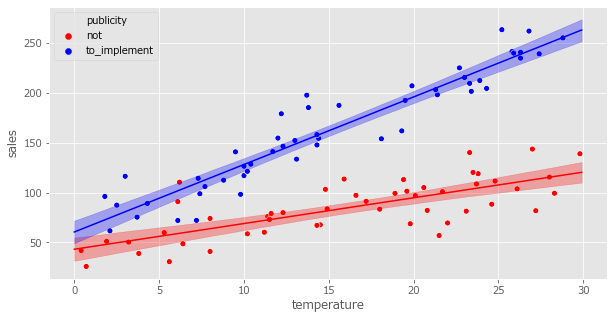

In [18]:
# グラフ描画領域の作成
plt.figure(figsize=(10, 5))

# 散布図の描画
sns.scatterplot(x='temperature',
                y='sales',
                data=interaction_2,
                hue='publicity',
                hue_order=['not', 'to_implement'],
                palette=['red', 'blue'])

# 宣伝がない日の売り上げを描画
plt.plot(mu_pred_not['temperature'],
         mu_pred_not["50%"],
         color='red')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=mu_pred_not['temperature'],
                 y1=mu_pred_not["2.5%"],
                 y2=mu_pred_not["97.5%"],
                 color='red',
                 alpha=0.3)

# 宣伝がある日の売り上げを描画
plt.plot(mu_pred_to_implement['temperature'],
         mu_pred_to_implement["50%"],
         color='blue')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=mu_pred_to_implement['temperature'],
                 y1=mu_pred_to_implement["2.5%"],
                 y2=mu_pred_to_implement["97.5%"],
                 color='blue',
                 alpha=0.3)

# グラフの描画
plt.show()